In [2]:
import requests
import json
import pandas as pd
import numpy as np
import fiona
import descartes
from shapely.geometry import Point, Polygon
import statsmodels.formula.api as smf
import matplotlib.pylab as plt
import math
import copy
import seaborn as sns 
%matplotlib inline

import nltk
import string
import nltk.stem
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk.stem
from PIL import Image
import sys
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
nltk.download('punkt')
import gensim
from gensim.models import Phrases
from gensim import corpora, models
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import seaborn as sea
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import re
import pyLDAvis
import pyLDAvis.gensim 

/Users/yanxu/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
[nltk_data] Downloading package punkt to /Users/yanxu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Text Cleaning

In [3]:
review=pd.read_csv("review_text.csv")
review=review.drop('Unnamed: 0', axis=1)
review.rating= pd.to_numeric(review.rating, errors='coerce')
review.head()

,Review_ID,text,rating,time,Business_ID,type,ratings,geo_id,geometry
0,3berq4jHTbnJExYCloPJtA,"Tim is awesome, educated, charismatic, and fun...",5.0,2017-06-09 10:57:21,mMxsS8Y6bv0zCRJpFAhbEA,Education,5.0,41051005000,POINT (-122.687461853027 45.5287284851074)
1,i8KATzD28BBplS_vXPp94A,I am a brand new actor with my only on-camera ...,5.0,2014-05-14 19:25:28,mMxsS8Y6bv0zCRJpFAhbEA,Education,5.0,41051005000,POINT (-122.687461853027 45.5287284851074)
2,r00ER6z9bS3Mmhabp1Om6g,My daughter decided that she wanted to get int...,5.0,2017-11-13 09:28:56,19mIUTnqfUQUu6TguP_6Ng,Education,5.0,41051005000,POINT (-122.6879303 45.5266776)
3,FnH40b4lFXxvHiAaLXur8Q,Both my daughters have taken weekly classes an...,5.0,2017-01-31 19:26:20,19mIUTnqfUQUu6TguP_6Ng,Education,5.0,41051005000,POINT (-122.6879303 45.5266776)
4,F1o2s5zP2BtwvEuSr2mSzg,Barbara's acting class and one on one training...,5.0,2017-11-01 16:01:04,j0TR9ZTc4HhwhaNDBwWlrA,Education,5.0,41051005000,POINT (-122.688015 45.526672)


In [130]:
### by types
R_type=review[['geo_id','text','rating','ratings','type']]
R_type.head()

,geo_id,text,rating,ratings,type
0,41051005000,"Tim is awesome, educated, charismatic, and fun...",5.0,5.0,Education
1,41051005000,I am a brand new actor with my only on-camera ...,5.0,5.0,Education
2,41051005000,My daughter decided that she wanted to get int...,5.0,5.0,Education
3,41051005000,Both my daughters have taken weekly classes an...,5.0,5.0,Education
4,41051005000,Barbara's acting class and one on one training...,5.0,5.0,Education


In [103]:
## data cleaning and get text phrases
text = R_type.text.values.tolist()
text = [re.sub('\s+', ' ', sent) for sent in text]
data = [re.sub("\'", "", sent) for sent in text]

def all_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data_words = list(all_words(data))

bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

<>:3: DeprecationWarning: invalid escape sequence \s
<>:3: DeprecationWarning: invalid escape sequence \s
<>:3: DeprecationWarning: invalid escape sequence \s
<ipython-input-103-e7639d0981ba>:3: DeprecationWarning: invalid escape sequence \s
  text = [re.sub('\s+', ' ', sent) for sent in text]


In [104]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','come','order','try','go',
                   'get','make','drink','plate','dish','restaurant','place','would',
                   'really','like','great','service','came','got','place','time','got',
                   'get','would','go','even','portland','one','first','day','area',
                    'year','went','look','help','alway','could','almost','several','many',
                  'always','years','came','really','location','hours','experience'])

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

data_words_nostops = remove_stopwords(data_words)
data_words_bigrams = make_bigrams(data_words_nostops)

### LDA Modeling

In [105]:
## generate corpus
id2word = corpora.Dictionary(data_words_bigrams)
texts = data_words_bigrams
corpus = [id2word.doc2bow(text) for text in texts]

In [106]:
### This step will cost some time
coherence_score = []
for i in range(5,16):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=i, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    coherence_model_lda = gensim.models.coherencemodel.CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_score.append(coherence_lda)

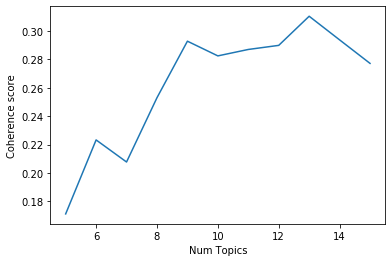

In [107]:
num_topic = [i for i in range(5,16)]

plt.plot(num_topic, coherence_score)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.show()

In [108]:
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus, id2word = id2word, num_topics = 13, 
                                           random_state = 100, update_every = 1, chunksize = 100,
                                           passes = 10, alpha = 'auto', per_word_topics = True)
lda_model.print_topics()

[(0,
  '0.067*"friendly" + 0.058*"car" + 0.042*"staff" + 0.039*"job" + 0.032*"done" + 0.031*"business" + 0.029*"made" + 0.027*"guys" + 0.025*"said" + 0.023*"fast"'),
 (1,
  '0.130*"called" + 0.088*"find" + 0.062*"working" + 0.051*"stopped" + 0.046*"feel" + 0.031*"beautiful" + 0.026*"owners" + 0.025*"breakfast" + 0.022*"afternoon" + 0.021*"event"'),
 (2,
  '0.099*"back" + 0.062*"took" + 0.056*"long" + 0.043*"excellent" + 0.032*"recently" + 0.031*"quick" + 0.025*"walked" + 0.024*"kids" + 0.024*"door" + 0.021*"life"'),
 (3,
  '0.059*"best" + 0.039*"us" + 0.036*"times" + 0.034*"little" + 0.030*"two" + 0.027*"much" + 0.021*"pizza" + 0.018*"mexican" + 0.016*"gave" + 0.016*"awesome"'),
 (4,
  '0.045*"need" + 0.043*"shop" + 0.042*"old" + 0.034*"give" + 0.028*"stars" + 0.028*"recommend" + 0.023*"saturday" + 0.023*"kind" + 0.022*"night" + 0.020*"full"'),
 (5,
  '0.087*"food" + 0.061*"ive" + 0.040*"amazing" + 0.040*"nice" + 0.027*"take" + 0.025*"super" + 0.022*"also" + 0.021*"house" + 0.020*"ever

### Sentiment Score

In [131]:
sid = SentimentIntensityAnalyzer()
R_type['sentiments'] = R_type['text'].apply(lambda x: sid.polarity_scores(x))
R_type = pd.concat([R_type.drop(['sentiments'], axis=1), R_type['sentiments'].apply(pd.Series)], axis=1)
R_type['sent'] = np.where(R_type['compound'] >= 0, 'positive', 'negative')
R_type.rename({'compound': 'sentiment_score','rating':'star_score'}, axis=1, inplace=True)
R_type['sent_val'] = np.where(R_type['sent'] == 'positive', 1, 0)

/Users/yanxu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [132]:
R_type.head()

,geo_id,text,star_score,ratings,type,neg,neu,pos,sentiment_score,sent,sent_val
0,41051005000,"Tim is awesome, educated, charismatic, and fun...",5.0,5.0,Education,0.000,0.532,0.468,0.9060,positive,1
1,41051005000,I am a brand new actor with my only on-camera ...,5.0,5.0,Education,0.000,1.000,0.000,0.0000,positive,1
2,41051005000,My daughter decided that she wanted to get int...,5.0,5.0,Education,0.094,0.906,0.000,-0.3612,negative,0
3,41051005000,Both my daughters have taken weekly classes an...,5.0,5.0,Education,0.049,0.951,0.000,-0.0772,negative,0
4,41051005000,Barbara's acting class and one on one training...,5.0,5.0,Education,0.000,0.767,0.233,0.7845,positive,1


In [134]:
R_type['rating_scores'] = R_type.ratings.apply(lambda x: 1 if x > 4.0 else(-1 if x<3.0 else 0))

In [135]:
test=R_type[['geo_id','type','sentiment_score','star_score','rating_scores']]
sentiment_avg=test.groupby(['geo_id','type']).mean()
sentiment_avg[0:12]

sentiment_score  star_score  rating_scores
geo_id      type                                                          
41051000100 Arts_Entertainment         0.479910    4.050000       0.450000
            Beauty&Spa                 0.553555    4.575758       1.000000
            Car                        0.408414    5.000000       0.571429
            Education                  0.382446    4.153846       0.538462
            Financial                  0.370267    3.818182       0.500000
            Home_Services              0.459271    4.428571       1.000000
            Nightlife                  0.557647    4.200000       0.400000
            Pets                       0.273746    3.846154       0.307692
            Shopping                   0.610651    4.617021       0.680851
            bicycles                   0.212417    4.833333       1.000000
            grocery                    0.423100    4.333333       0.500000
            restaurant                 0.615001    4.481481       0.444444

In [136]:
df=R_type[['geo_id','type','sentiment_score']]
s=df.groupby(['geo_id','type']).mean().unstack().fillna(0)
s.columns = s.columns.droplevel()
s

type,Arts_Entertainment,Beauty&Spa,Car,Education,Financial,Home_Services,Nightlife,Pets,Shopping,bicycles,grocery,hotel,restaurant
geo_id,,,,,,,,,,,,,
41051000100,0.479910,0.553555,0.408414,0.382446,0.370267,0.459271,0.557647,0.273746,0.610651,0.212417,0.423100,0.000000,0.615001
41051000200,0.480322,0.520100,0.303358,0.739760,0.157044,0.765933,0.089467,0.459483,0.673250,0.000000,0.138017,0.000000,0.457639
41051000302,0.000000,0.510700,-0.205033,0.212560,0.000000,0.827733,0.000000,0.000000,0.000000,0.000000,0.423233,0.000000,0.648400
41051000401,0.000000,0.421394,0.079733,0.000000,0.217276,0.000000,0.472350,0.529200,0.554344,0.271067,0.252833,0.000000,0.503707
41051000502,0.256117,0.494136,0.344460,0.583457,0.000000,0.520843,0.276662,0.607533,0.408612,0.000000,0.390033,0.000000,0.430936
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41051010304,0.000000,0.000000,0.000000,0.000000,0.000000,0.460083,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
41051010408,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.126367,0.000000,0.000000,0.000000,0.000000,0.000000
41051010410,0.000000,0.000000,0.000000,0.000000,0.000000,0.600867,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Data visualization

In [98]:
def sentiment_score(geoid):
    
    colors=['darkcyan','cadetblue','powderblue','skyblue','lightskyblue',
        'thistle','mistyrose','lightpink','pink','lightcoral','indianred','salmon','red']
    
    value=s.loc[geoid]     
    value.plot.bar(width=0.6,color=colors)
    plt.title('sentiment score')

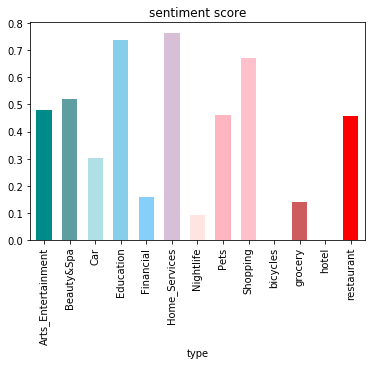

In [101]:
sentiment_score(41051000200)

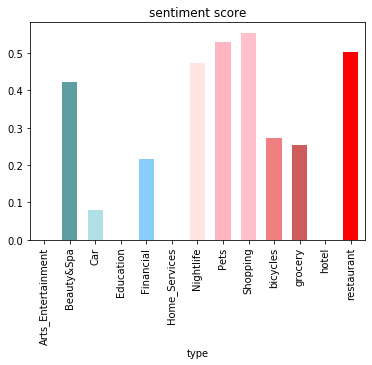

In [102]:
sentiment_score(41051000401)

### Merge With NAICS_CODE

In [121]:
NAICS=pd.read_csv("Final_merged_city_portland_with_NAICS.csv")
NAICS=NAICS.drop('Unnamed: 0', axis=1)
NAICS=NAICS.drop('Unnamed: 0.1', axis=1)
#review.rating= pd.to_numeric(review.rating, errors='coerce')
NAICS

,geo_id,centroid,year,geometry,total_tran,pop,edut,collegemale,collegefemale,households,...,ratio_22_50,bus_ratio,bus_ratio_total,public_ratio,car_ratio,bicy_ratio,walked_ratio,maxNaics_est,totalEstab,maxNaics_emp
0,41051010402,POINT (-122.3356996936241 45.48566422279789),2010,MULTIPOLYGON (((-122.3868792758254 45.51902980...,2601.0,5717.0,3699.0,294.0,356.0,162.0,...,0.091307,0.490196,0.009612,0.019608,0.891580,0.005767,0.014994,23,95,23
1,41051010402,POINT (-122.3356996936241 45.48566422279789),2011,MULTIPOLYGON (((-122.3868792758254 45.51902980...,2826.0,6037.0,4024.0,368.0,476.0,149.0,...,0.108001,0.305970,0.014508,0.047417,0.866596,0.030432,0.009908,23,92,23
2,41051010402,POINT (-122.3356996936241 45.48566422279789),2012,MULTIPOLYGON (((-122.3868792758254 45.51902980...,2868.0,6153.0,4090.0,369.0,507.0,139.0,...,0.109052,0.266667,0.011158,0.041841,0.857043,0.033473,0.004533,23,85,23
3,41051010402,POINT (-122.3356996936241 45.48566422279789),2013,MULTIPOLYGON (((-122.3868792758254 45.51902980...,2876.0,6022.0,3931.0,296.0,404.0,129.0,...,0.108602,0.321739,0.012865,0.039986,0.858832,0.025730,0.012517,23,86,23
4,41051010402,POINT (-122.335683996136 45.48565935229686),2014,MULTIPOLYGON (((-122.3868792758254 45.51902980...,3078.0,6181.0,4094.0,316.0,457.0,120.0,...,0.108720,0.264368,0.007472,0.028265,0.875569,0.016244,0.023392,23,89,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,41051008500,POINT (-122.547126858435 45.48282091614918),2017,MULTIPOLYGON (((-122.5574044200961 45.47833505...,2214.0,4518.0,3076.0,96.0,223.0,124.0,...,0.137450,0.954733,0.104788,0.109756,0.837398,0.000000,0.015357,72,122,72
4996,41051008600,POINT (-122.5841997909028 45.46868321437336),2017,MULTIPOLYGON (((-122.589348427813 45.468646920...,2217.0,4008.0,2901.0,152.0,278.0,125.0,...,0.093313,1.000000,0.114118,0.114118,0.746504,0.009923,0.009021,72,122,72
4997,41051008901,POINT (-122.5169172531085 45.47031142766809),2017,MULTIPOLYGON (((-122.5493773955564 45.47604007...,4074.0,9634.0,6682.0,610.0,560.0,161.0,...,0.148952,0.567227,0.033137,0.058419,0.873098,0.003927,0.021846,72,122,72
4998,41051008902,POINT (-122.5605713255571 45.46745111423488),2017,MULTIPOLYGON (((-122.5790413899689 45.46437394...,2146.0,3974.0,2720.0,352.0,297.0,119.0,...,0.104177,0.745665,0.060112,0.080615,0.769804,0.032619,0.046598,72,122,72


In [123]:
NAICS.loc[NAICS['year']==2017]
#df.loc[df['column_name'] == some_value]


,geo_id,centroid,year,geometry,total_tran,pop,edut,collegemale,collegefemale,households,...,ratio_22_50,bus_ratio,bus_ratio_total,public_ratio,car_ratio,bicy_ratio,walked_ratio,maxNaics_est,totalEstab,maxNaics_emp
7,41051010402,POINT (-122.3356596646475 45.48564052912985),2017,MULTIPOLYGON (((-122.3868792758254 45.51902980...,3456.0,6981.0,4633.0,399.0,485.0,115.0,...,0.133792,0.867188,0.032118,0.037037,0.882523,0.000000,0.035880,23,97,23
1352,41051010500,POINT (-122.0852430195605 45.52765726906909),2017,MULTIPOLYGON (((-122.3970989671113 45.57260058...,1535.0,3912.0,2732.0,245.0,306.0,122.0,...,0.214468,0.000000,0.000000,0.037785,0.833876,0.005863,0.016938,42,4,42
1353,41051010500,POINT (-122.0852430195605 45.52765726906909),2017,MULTIPOLYGON (((-122.3970989671113 45.57260058...,1535.0,3912.0,2732.0,245.0,306.0,122.0,...,0.214468,0.000000,0.000000,0.037785,0.833876,0.005863,0.016938,42,4,42
1354,41051010500,POINT (-122.0852430195605 45.52765726906909),2017,MULTIPOLYGON (((-122.3970989671113 45.57260058...,1535.0,3912.0,2732.0,245.0,306.0,122.0,...,0.214468,0.000000,0.000000,0.037785,0.833876,0.005863,0.016938,42,4,42
1355,41051010500,POINT (-122.0852430195605 45.52765726906909),2017,MULTIPOLYGON (((-122.3970989671113 45.57260058...,1535.0,3912.0,2732.0,245.0,306.0,122.0,...,0.214468,0.000000,0.000000,0.037785,0.833876,0.005863,0.016938,42,4,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,41051008500,POINT (-122.547126858435 45.48282091614918),2017,MULTIPOLYGON (((-122.5574044200961 45.47833505...,2214.0,4518.0,3076.0,96.0,223.0,124.0,...,0.137450,0.954733,0.104788,0.109756,0.837398,0.000000,0.015357,72,122,72
4996,41051008600,POINT (-122.5841997909028 45.46868321437336),2017,MULTIPOLYGON (((-122.589348427813 45.468646920...,2217.0,4008.0,2901.0,152.0,278.0,125.0,...,0.093313,1.000000,0.114118,0.114118,0.746504,0.009923,0.009021,72,122,72
4997,41051008901,POINT (-122.5169172531085 45.47031142766809),2017,MULTIPOLYGON (((-122.5493773955564 45.47604007...,4074.0,9634.0,6682.0,610.0,560.0,161.0,...,0.148952,0.567227,0.033137,0.058419,0.873098,0.003927,0.021846,72,122,72
4998,41051008902,POINT (-122.5605713255571 45.46745111423488),2017,MULTIPOLYGON (((-122.5790413899689 45.46437394...,2146.0,3974.0,2720.0,352.0,297.0,119.0,...,0.104177,0.745665,0.060112,0.080615,0.769804,0.032619,0.046598,72,122,72


### Spatial Data visualization

In [19]:
import geopandas as gpd
import matplotlib.pylab as plt
import fiona
import descartes
from shapely.geometry import Point, Polygon
from shapely import wkt

In [20]:
#Get Porland Geoinformation
portland=pd.read_csv("Final_merged_city_portland.csv")
Portland=portland[portland['year']==2017]
P_Geo=Portland[['geo_id','geometry']]
P_Geo.head()


,geo_id,geometry
7,41051010402,MULTIPOLYGON (((-122.3868792758254 45.51902980...
15,41051010500,MULTIPOLYGON (((-122.3970989671113 45.57260058...
23,41051010500,MULTIPOLYGON (((-122.3970989671113 45.57260058...
31,41051009603,MULTIPOLYGON (((-122.4661255423961 45.53952849...
39,41051010100,MULTIPOLYGON (((-122.4566475168594 45.53948853...


/Users/yanxu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/yanxu/anaconda3/lib/python3.7/site-packages/pyproj/crs.py:114: DeprecationWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  DeprecationWarning,


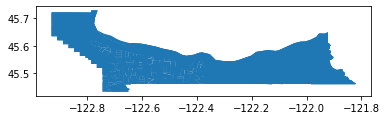

In [21]:
P_Geo['geometry'] = P_Geo['geometry'].apply(wkt.loads)
#crs = {'init':'epsg:4326'}
P_G = gpd.GeoDataFrame(P_Geo, geometry='geometry')
# Building the GeoDataframe 
crs = {'init':'epsg:4326'}
P_G = gpd.GeoDataFrame(P_G,crs=crs, geometry='geometry')
P_G .plot()

In [22]:
s=P_G.merge(s,on='geo_id')
s.head()

,geo_id,geometry,Arts_Entertainment,Beauty&Spa,Car,Education,Financial,Home_Services,Nightlife,Pets,Shopping,bicycles,grocery,hotel,restaurant
0,41051009603,"MULTIPOLYGON (((-122.46613 45.53953, -122.4615...",0.0,0.0,0.0,0.0000,0.5168,-0.16982,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
1,41051009603,"MULTIPOLYGON (((-122.46613 45.53953, -122.4615...",0.0,0.0,0.0,0.0000,0.5168,-0.16982,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
2,41051009603,"MULTIPOLYGON (((-122.46613 45.53953, -122.4615...",0.0,0.0,0.0,0.0000,0.5168,-0.16982,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
3,41051010100,"MULTIPOLYGON (((-122.45665 45.53949, -122.4533...",0.0,0.0,0.0,0.4404,0.3081,0.62490,0.0,0.0,0.0,0.0,0.0,0.0,0.3803
4,41051010100,"MULTIPOLYGON (((-122.45665 45.53949, -122.4533...",0.0,0.0,0.0,0.4404,0.3081,0.62490,0.0,0.0,0.0,0.0,0.0,0.0,0.3803



                     Distribution of different types of small businesses in each GeoId



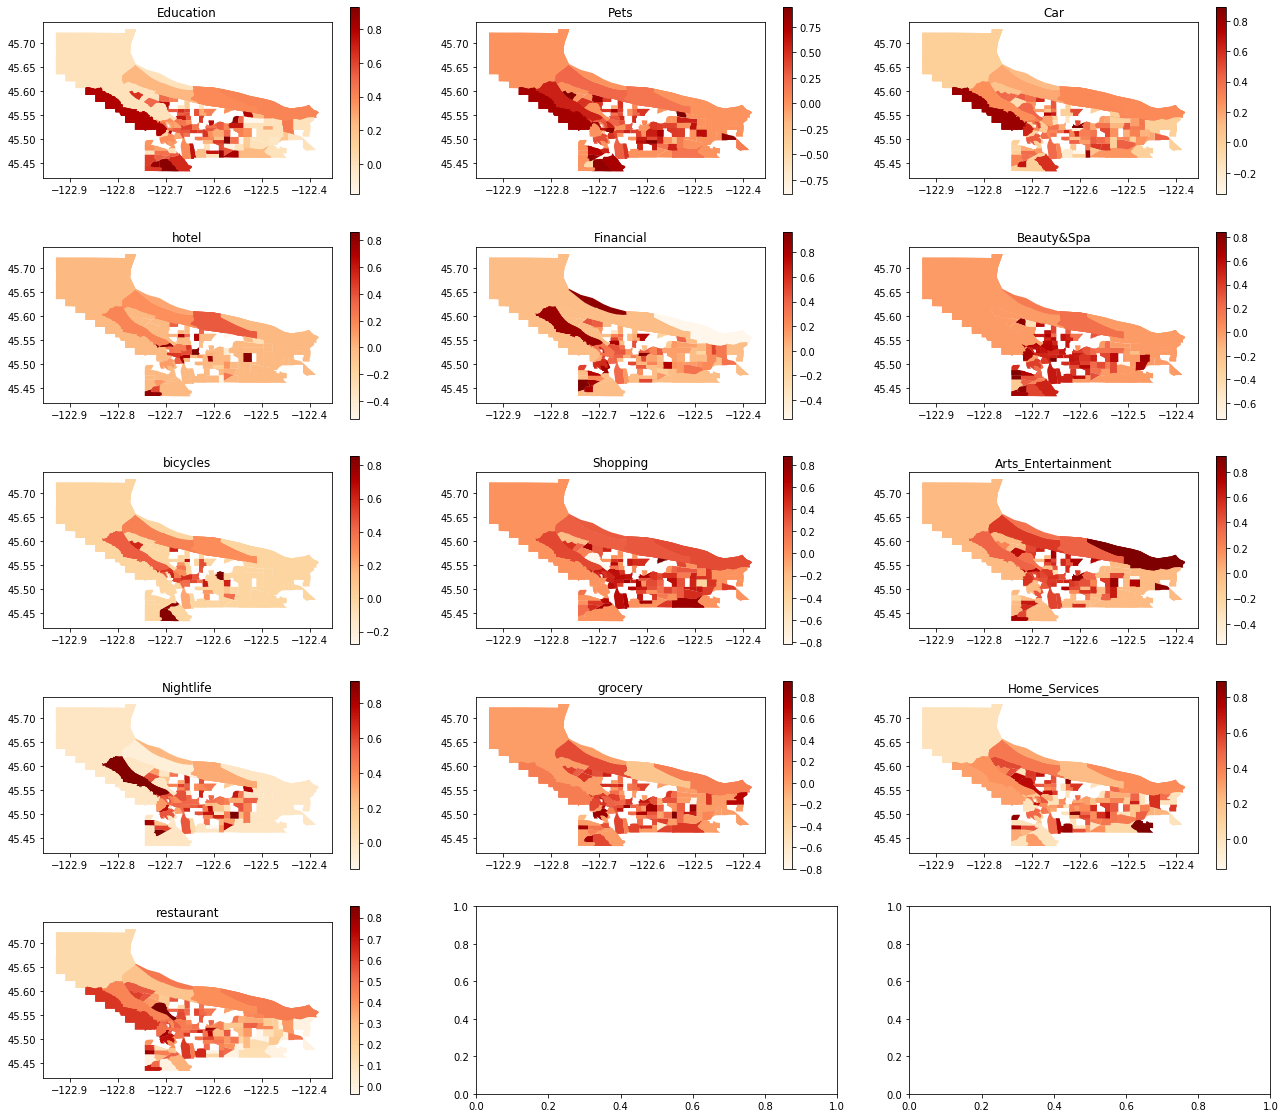

In [23]:
types=['Education','Pets','Car','hotel','Financial','Beauty&Spa',
       'bicycles','Shopping','Arts_Entertainment',
       'Nightlife','grocery','Home_Services','restaurant']
print()
print('                     Distribution of different types of small businesses in each GeoId')
print()
f1, ax = plt.subplots(5,3, figsize=(22,20))
index = 0
for i in range(5):
    for j in range(3):
        ax[i,j].set_title(types[index], fontsize=12) 
        s.plot(ax=ax[i,j], column=types[index],cmap='OrRd',legend=True)
        index += 1
        if index >= 13:
            break
    if index >= 13:
        break
#f1.savefig('Distribution of different types.png', dpi=300)